In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import utils

In [2]:
ROOT_PATH = Path('data/q1a')
OBJ_DATA_PATH = ROOT_PATH / 'bench'
GT_DATA_PATH = OBJ_DATA_PATH / 'gt.npz'
CORRESP_DATA_PATH = OBJ_DATA_PATH / 'corresp.npz'
INTRINSICS_PATH = OBJ_DATA_PATH / 'intrinsics.npz'
IMG1_PATH = OBJ_DATA_PATH / 'image1.jpg'
IMG2_PATH = OBJ_DATA_PATH / 'image2.jpg'

In [3]:
IMG1 = utils.load_image(IMG1_PATH)
IMG2 = utils.load_image(IMG2_PATH)

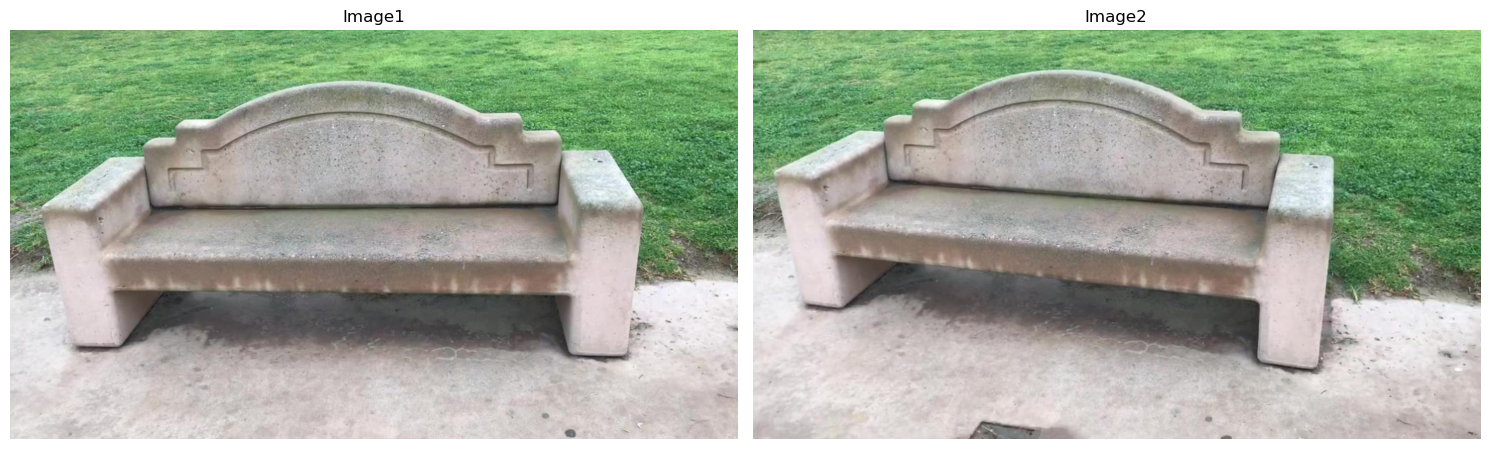

In [4]:
utils.show_images([IMG1, IMG2], ['Image1', 'Image2'])

In [5]:
K1 = np.load(INTRINSICS_PATH)['K1']
K2 = np.load(INTRINSICS_PATH)['K2']
print(f'K1: {K1.shape}\n{K1}')
print(f'K2: {K2.shape}\n{K2}')

K1: (3, 3)
[[1.24569079e+03 0.00000000e+00 6.32500000e+02]
 [0.00000000e+00 1.24569079e+03 3.56000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
K2: (3, 3)
[[1.24712691e+03 0.00000000e+00 6.33000000e+02]
 [0.00000000e+00 1.24712691e+03 3.56000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [6]:
pts1 = np.load(CORRESP_DATA_PATH)['pts1']
pts2 = np.load(CORRESP_DATA_PATH)['pts2']
print(f'pts1: {pts1.shape}\n{pts1}')
print(f'pts2: {pts2.shape}\n{pts2}')

pts1: (8, 2)
[[ 274.54720989  243.60492764]
 [ 333.48438839  209.64501685]
 [ 841.30978261  202.96310869]
 [ 908.12891304  234.70219565]
 [ 161.98195652  331.0331087 ]
 [1014.48269565  226.90663043]
 [ 774.49065217  568.79784783]
 [ 278.91543478  430.70497826]]
pts2: (8, 2)
[[253.48943136 201.73425741]
 [307.81448404 173.01581638]
 [788.02026049 198.74678304]
 [852.40744329 235.64346404]
 [115.58469816 275.67859054]
 [954.00309147 235.16520549]
 [676.14942043 558.87877899]
 [217.47723331 378.14191284]]


In [7]:
F = utils.compute_F_8points(pts1, pts2)
print("Fundmental Matrix F:\n", F)

Fundmental Matrix F:
 [[-1.46486423e-08 -3.11057196e-07  2.54961985e-05]
 [-4.86952282e-08  2.78927493e-08  3.05667982e-03]
 [-1.31286915e-04 -2.82557971e-03  1.22823460e-01]]


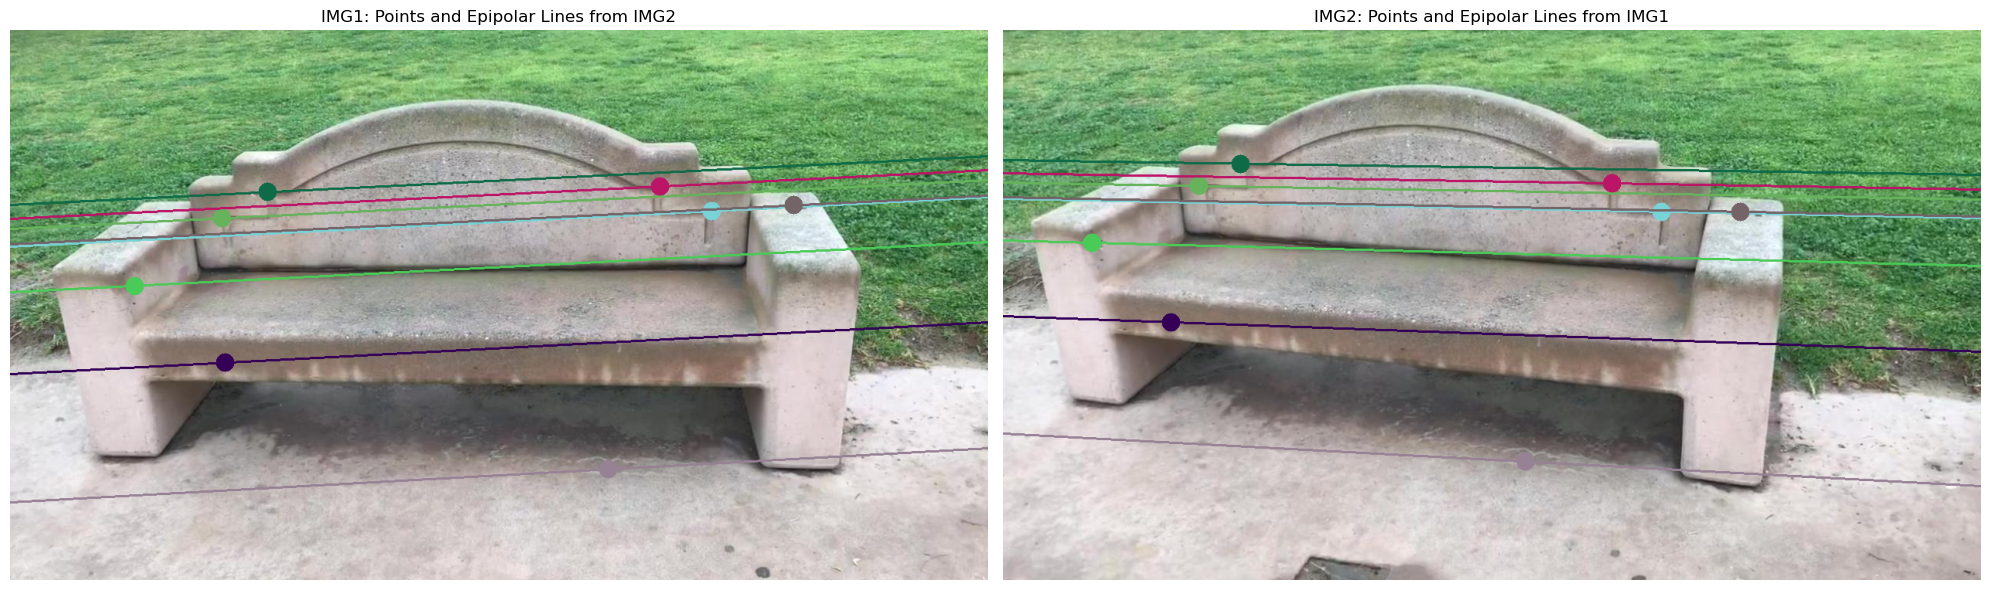

In [8]:
def draw_epipolar_viz(img1, img2, pts1, pts2, F):
    out1 = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2RGB)
    out2 = cv2.cvtColor(img2.copy(), cv2.COLOR_BGR2RGB)
    
    h, w = out1.shape[:2]
    
    pts1_h = np.column_stack((pts1, np.ones(len(pts1))))
    lines2 = (F @ pts1_h.T).T 
    
    pts2_h = np.column_stack((pts2, np.ones(len(pts2))))
    lines1 = (F.T @ pts2_h.T).T

    np.random.seed(42)
    colors = np.random.randint(0, 255, (len(pts1), 3)).tolist()

    for i in range(len(pts1)):
        color = colors[i]
        
        l1 = lines1[i]
        x0, y0 = 0, int(-l1[2] / l1[1])
        x1, y1 = w, int(-(l1[2] + l1[0] * w) / l1[1])
        cv2.line(out1, (x0, y0), (x1, y1), color, 2)
        cv2.circle(out1, tuple(pts1[i].astype(int)), 12, color, -1)
        
        l2 = lines2[i]
        x0, y0 = 0, int(-l2[2] / l2[1])
        x1, y1 = w, int(-(l2[2] + l2[0] * w) / l2[1])
        cv2.line(out2, (x0, y0), (x1, y1), color, 2)
        cv2.circle(out2, tuple(pts2[i].astype(int)), 12, color, -1)

    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(out1)
    plt.title("IMG1: Points and Epipolar Lines from IMG2")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(out2)
    plt.title("IMG2: Points and Epipolar Lines from IMG1")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualization
draw_epipolar_viz(IMG1, IMG2, pts1, pts2, F)

In [9]:
E_raw = K2.T @ F @ K1

U, S, Vt = np.linalg.svd(E_raw)

average_scale = (S[0] + S[1]) / 2.0

E = U @ np.diag([average_scale, average_scale, 0]) @ Vt

print("Essential Matrix E:\n", E)

Essential Matrix E:
 [[-0.02275717 -0.48323809 -0.11786026]
 [-0.07564972  0.04333235  3.78604025]
 [-0.19668836 -3.75270465  0.0548045 ]]


In [11]:
p1_h = np.array([pts1[0,0], pts1[0,1], 1])
p2_h = np.array([pts2[0,0], pts2[0,1], 1])

p1_norm = np.linalg.inv(K1) @ p1_h
p2_norm = np.linalg.inv(K2) @ p2_h

error = p2_norm.T @ E @ p1_norm
print(f"Error for point 0: {error:.6f}")

Error for point 0: -0.000000
